Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


### Импорты

In [ ]:
# Работа со временем
import time

# Работа с архивами
import zipfile

# Работа с файлами
from pathlib import Path

# ЗАгрузка данных
import gdown

# Работа с графиками
import matplotlib.pyplot as plt

# Работа с массивами данных
import numpy as np

# Работа с матрицами ошибок
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Работа с весами классов
from sklearn.utils.class_weight import compute_class_weight

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Основные слои
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    SpatialDropout1D,
)

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Оптимизаторы для обучения нейронной сети
from tensorflow.keras.optimizers import Adam

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

### Загрузка и распаковка данных

In [ ]:
if not Path("20writers").exists():
    # Скачивание архива с данными
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip",
        None,
        quiet=True,
    )

# Распаковка архива с данными
with zipfile.ZipFile("20writers.zip", "r") as zip_ref:
    zip_ref.extractall("20writers")

# Вывод списка файлов в папке с данными
print(
    "Список файлов в папке 20writers: \n",
    "\n".join([p.name for p in (Path("20writers").glob("*"))]),
)


Список файлов в папке 20writers: 
 Пушкин.txt
Тургенев.txt
Лермонтов.txt
Гончаров.txt
Грибоедов.txt
Катаев.txt
Каверин.txt
Лесков.txt
Булгаков.txt
Носов.txt
Чехов.txt
Достоевский.txt
Беляев.txt
Пастернак.txt
Шолохов.txt
Васильев.txt
Куприн.txt
Горький.txt
Толстой.txt
Гоголь.txt


### Подготовка данных

In [17]:
path = Path("20writers")  # Путь к папке с данными
text = []  # Список для хранения текстов
class_names = []  # Список для хранения названий классов
for f in path.iterdir():  # Перебираем файлы в папке
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))

In [18]:
text_lens = [len(t) for t in text]  # Длина каждого текста

# Индексы для разделения на обучающую и тестовую выборки
split_indices = [int(lenth * 0.8) for lenth in text_lens]

In [19]:
print(text_lens) # Выводим длины текстов

[3408339, 1980206, 1972541, 3104712, 969109, 2579246, 1992830, 2152214, 2001064, 2399413, 6611627, 5178950, 2255254, 3089426, 3386268, 2952792, 2328900, 2523380, 3357061, 1965119]


In [20]:
train_text = []  # Список для хранения обучающих текстов
test_text = []  # Список для хранения тестовых текстов
for i, t in enumerate(text):  # Перебираем тексты, разделяя их на обучающие и тестовые
    train_text.append(t[: split_indices[i]])
    test_text.append(t[split_indices[i] :])

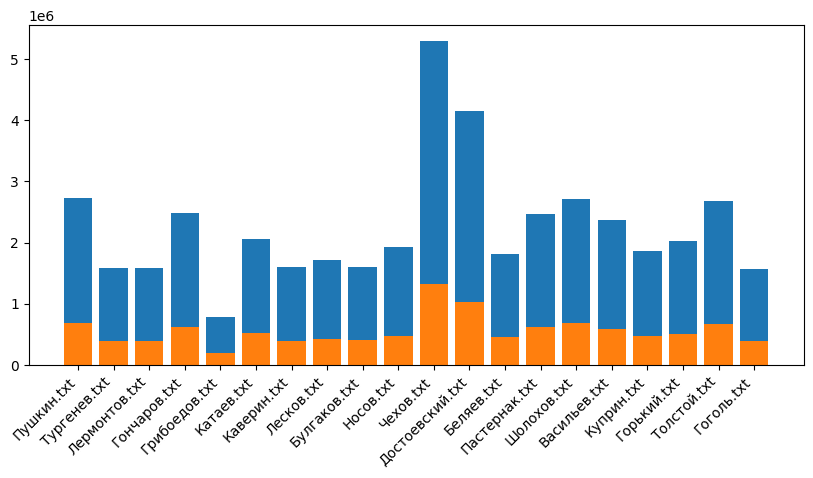

In [21]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = split_indices
c_test = [i - j for i, j in zip(text_lens, split_indices)]
plt.bar(class_names, c_train)
plt.bar(class_names, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()


#### Настройка токенайзера и деление последовательности индексов на окна

In [22]:
# Параметры для токенизации
VOCAB_SIZE = 25_000
WIN_SIZE = 4000
WIN_HOPE = 500


# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)


In [23]:
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))


In [24]:
with timex():
    tokenizer = Tokenizer(  # Инициализация токенизатора
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    # Обучение токенизатора на текстах
    tokenizer.fit_on_texts(text)
    # Преобразование текстов в последовательности индексов
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)
with timex():
    x_train_matrix = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
with timex():
    x_test_matrix = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")


Время обработки: 18.63 с
Время обработки: 10.63 с
Время обработки: 2.20 с


In [25]:
# Преобразуем one-hot обратно в метки классов
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Подсчёт с помощью bincount
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Вывод результатов
print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")


Обучающая выборка:
Класс 0: 823 окон
Класс 1: 484 окон
Класс 2: 488 окон
Класс 3: 780 окон
Класс 4: 239 окон
Класс 5: 602 окон
Класс 6: 479 окон
Класс 7: 537 окон
Класс 8: 470 окон
Класс 9: 586 окон
Класс 10: 1656 окон
Класс 11: 1294 окон
Класс 12: 532 окон
Класс 13: 726 окон
Класс 14: 791 окон
Класс 15: 706 окон
Класс 16: 558 окон
Класс 17: 647 окон
Класс 18: 829 окон
Класс 19: 479 окон

Тестовая выборка:
Класс 0: 194 окон
Класс 1: 116 окон
Класс 2: 117 окон
Класс 3: 188 окон
Класс 4: 52 окон
Класс 5: 143 окон
Класс 6: 115 окон
Класс 7: 121 окон
Класс 8: 111 окон
Класс 9: 150 окон
Класс 10: 422 окон
Класс 11: 327 окон
Класс 12: 127 окон
Класс 13: 171 окон
Класс 14: 201 окон
Класс 15: 169 окон
Класс 16: 134 окон
Класс 17: 153 окон
Класс 18: 206 окон
Класс 19: 115 окон


### Создание и обучение модели с учетом весов классов

In [26]:
class_weights = compute_class_weight(  # Вычисление весов классов
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
class_weight_dict = dict(enumerate(class_weights))  # Преобразование в словарь

In [ ]:
model = Sequential(  # Создание модели нейронной сети
    [
        Input((VOCAB_SIZE,)),
        Dropout(0.6),
        Dense(64, activation="relu"),
        Dropout(0.6),
        Dense(20, activation="softmax"),
    ]
)
# Компиляция модели с оптимизатором Adam и функцией потерь categorical_crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()  # Вывод структуры модели

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,600,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601,364 (6.11 MB)

 Trainable params: 1,601,364 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(  # Обучение модели с использованием словаря весов классов
    x_train_matrix,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test_matrix, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.2617 - loss: 2.4394 - val_accuracy: 0.9496 - val_loss: 0.6083
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8850 - loss: 0.4472 - val_accuracy: 0.9715 - val_loss: 0.2711
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9486 - loss: 0.2114 - val_accuracy: 0.9739 - val_loss: 0.1901
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9711 - loss: 0.1351 - val_accuracy: 0.9739 - val_loss: 0.1475
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9739 - loss: 0.1040 - val_accuracy: 0.9751 - val_loss: 0.1284
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9792 - loss: 0.0832 - val_accuracy: 0.9742 - val_loss: 0.1227
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9813 - loss: 0.0757 - val_accuracy: 0.9751 - val_loss: 0.1165
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9812 - loss: 0.0679 - val_accuracy: 0.9757 - 

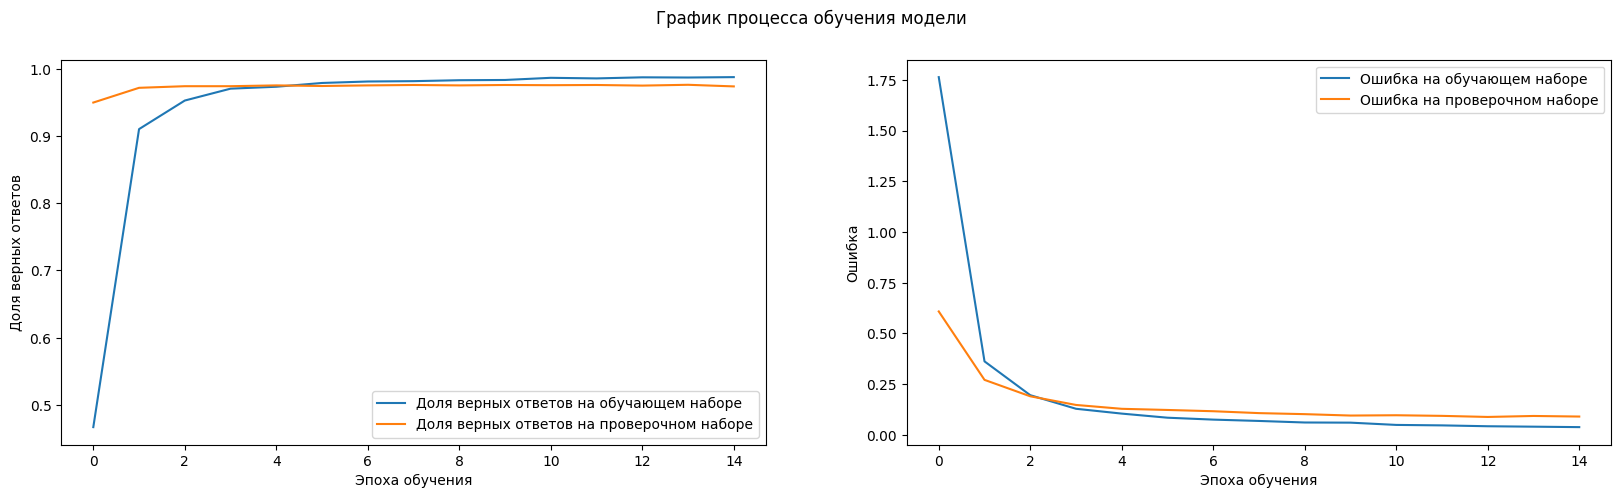

In [ ]:
# Отрисовка графиков обучения модели
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()


### Функция для проверки модели, вывода матрицы ошибок

In [ ]:
# Функция для оценки модели и построения матрицы ошибок
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется
    # как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


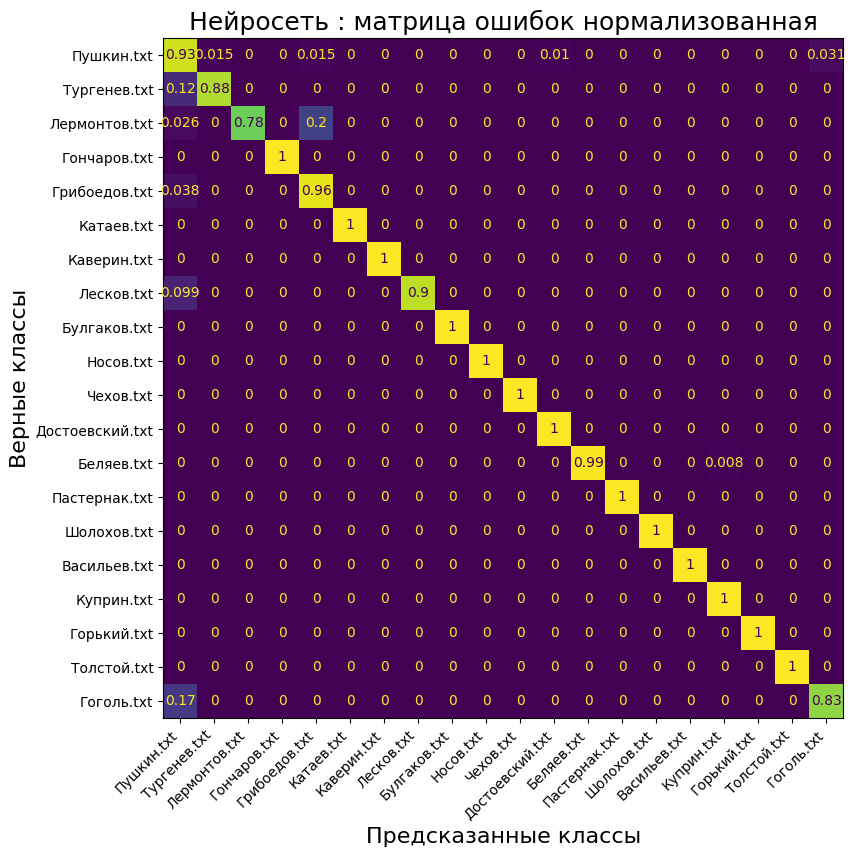

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Пушкин.txt            93% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Тургенев.txt          88% сеть отнесла к классу Тургенев.txt         - ВЕРНО :-)
Класс: Лермонтов.txt         78% сеть отнесла к классу Лермонтов.txt        - ВЕРНО :-)
Класс: Гончаров.txt         100% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Грибоедов.txt         96% сеть отнесла к классу Грибоедов.txt        - ВЕРНО :-)
Класс: Катаев.txt           100% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Каверин.txt          100% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Лесков.txt            90% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Булгаков.txt         100% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Носов.txt            100% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: 

In [ ]:
# Оценка модели на тестовой выборке и построение матрицы ошибок
eval_model(model, x_test_matrix, y_test, class_names)

### Создание и обучение модели с использованием Embedding слоя, с учетом весов классов

In [29]:
model_emb = Sequential(
    [
        Embedding(VOCAB_SIZE, 400),
        SpatialDropout1D(0.4),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(20, activation="softmax"),
    ]
)
model_emb.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_emb.build((None, x_train.shape[1]))  # Определение формы входных данных

model_emb.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 4000, 400)      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 4000, 400)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │   102,400,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,401,364 (428.78 MB)

 Trainable params: 112,401,364 (428.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_emb = model_emb.fit(  # Обучение модели с эмбеддингами
    x_train,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.1205 - loss: 2.8712 - val_accuracy: 0.4610 - val_loss: 1.9185
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8162 - loss: 0.6155 - val_accuracy: 0.8250 - val_loss: 0.8952
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9884 - loss: 0.0680 - val_accuracy: 0.8409 - val_loss: 0.7366
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9961 - loss: 0.0310 - val_accuracy: 0.8388 - val_loss: 0.6884
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9974 - loss: 0.0262 - val_accuracy: 0.8541 - val_loss: 0.6146
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9992 - loss: 0.0143 - val_accuracy: 0.8424 - val_loss: 0.6487
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9986 - loss: 0.0132 - val_accuracy: 0.8589 - val_loss: 0.5785
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9978 - loss: 0.0122 - val_accuracy: 0.8550 

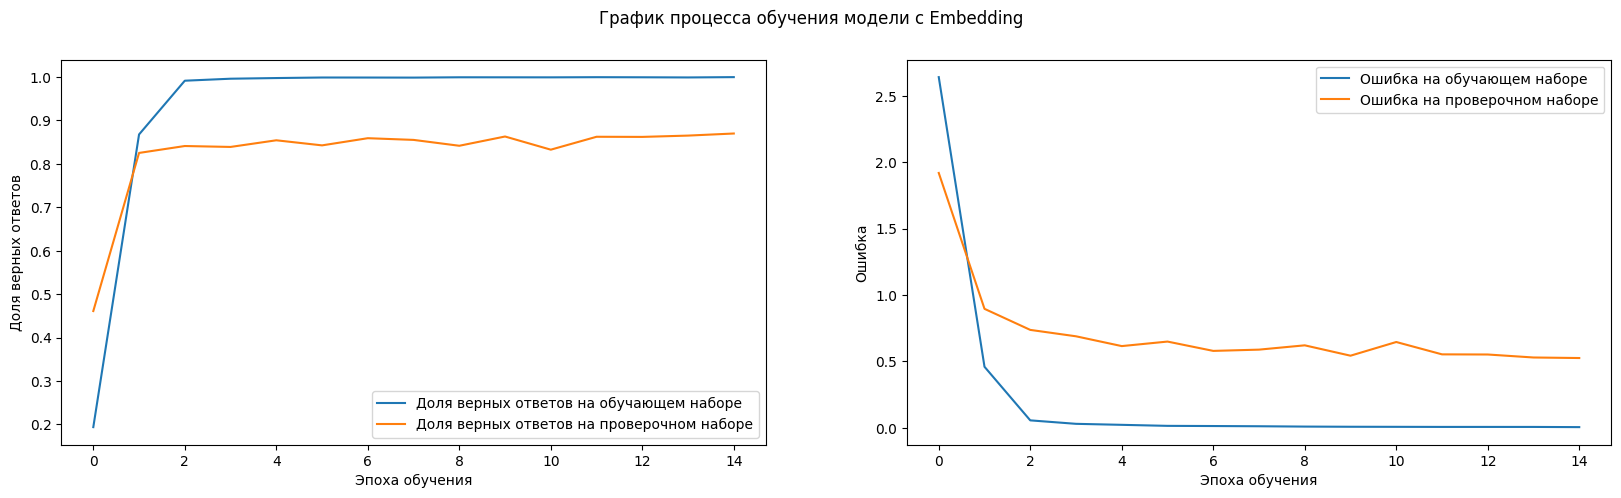

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


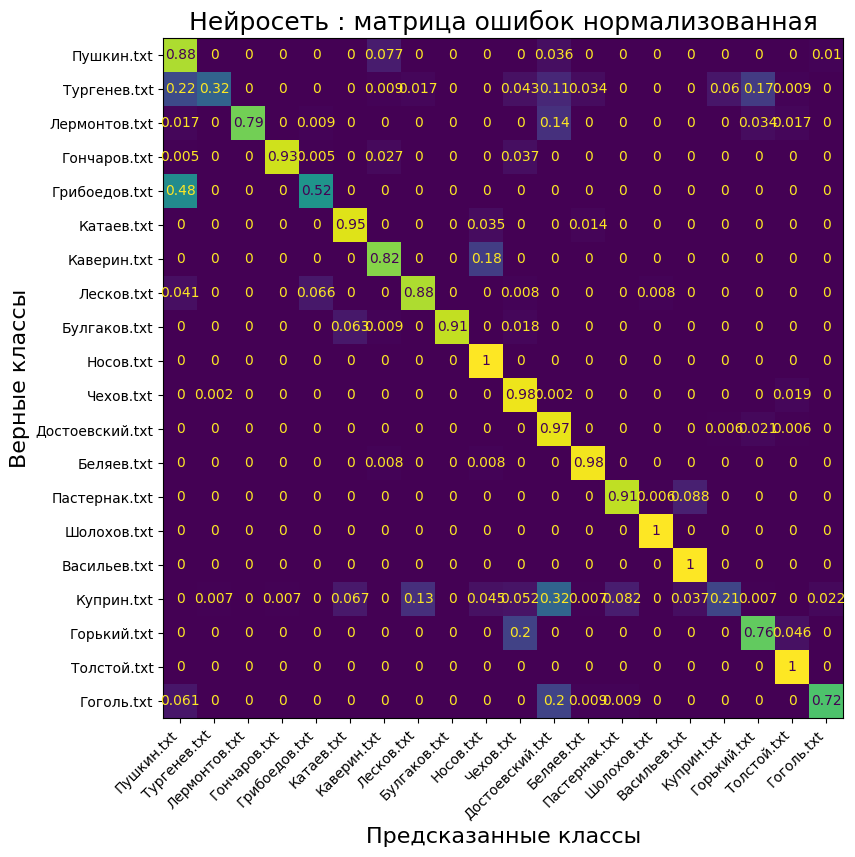

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Пушкин.txt            88% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Тургенев.txt          32% сеть отнесла к классу Тургенев.txt         - ВЕРНО :-)
Класс: Лермонтов.txt         79% сеть отнесла к классу Лермонтов.txt        - ВЕРНО :-)
Класс: Гончаров.txt          93% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Грибоедов.txt         52% сеть отнесла к классу Грибоедов.txt        - ВЕРНО :-)
Класс: Катаев.txt            95% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Каверин.txt           82% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Лесков.txt            88% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Булгаков.txt          91% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Носов.txt            100% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: 

In [ ]:
# Построение графиков обучения модели с эмбеддингами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели с Embedding")
ax1.plot(
    history_emb.history["accuracy"], label="Доля верных ответов на обучающем наборе"
)
ax1.plot(
    history_emb.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_emb.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_emb.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()
# Оценка модели с эмбеддингами на тестовой выборке и построение матрицы ошибок
eval_model(model_emb, x_test, y_test, class_names)